# Goal
- Align the spatial data to histology image
- Optional: collapse 2 pucks (2 differt slices, but so close that cna be considered as one)

In [1]:
%load_ext autoreload
%autoreload 2


import scanpy as sc
import seaborn as sns
import pandas as pd
from scipy.stats import median_abs_deviation
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt
import scrublet as scr
from tqdm.notebook import tqdm
from diptest import diptest
from scipy.sparse import csr_matrix
import anndata as ad
import math
import scvi
from dotenv import load_dotenv; load_dotenv()
import json
import os


from utils import preprocessing

# Hyperparamyters
ADATA_PATH = "/home/gdallagl/myworkdir/XDP/data/XDP/disease/diseased_1/diseased_1_adata.h5ad"
NISSEL_IMAGE_PATH = "/home/gdallagl/myworkdir/XDP/data/XDP/disease/diseased_1/images/XDP_CAP_Nissl.jpg"

# Prerequisites

Download all tools and data necessary for manual alignement on yout PC.

Follow info at: [https://github.com/mukundraj/slidetag-pipeline?tab=readme-ov-file](mukundraj/slidetag-pipeline)

In [2]:
adata = sc.read_h5ad(ADATA_PATH)
adata

AnnData object with n_obs × n_vars = 84669 × 32780
    obs: 'x', 'y', 'pct_intronic', 'is_cell', 'dbscan_clusters', 'dbscan_score', 'has_spatial', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability', 'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'my_hierarchy', 'my_hierarchy_all', 'library', 'library_name', 'leiden_scANVI', 'category_all_cell_types', 'category_only_SPN', 'category_striosome_matrix', 'category_dorsal_ventral', 'category_d1_d2', 'category_intrinsic

# Prepare coord csv of single slice for registration

In [3]:
CELL_TYPE_FOR_DISCRIMINATION = "neuron"
CELL_TYPE_ANNOTATION = "category_neuron_only"

## Split 2 Slices and Center

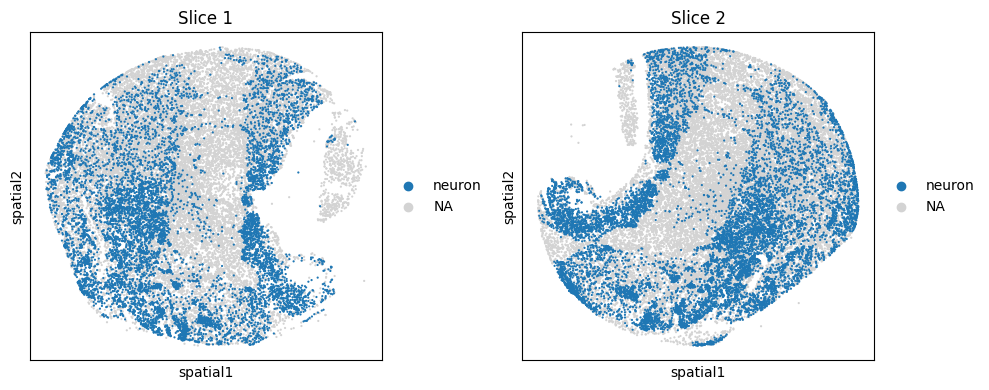

In [4]:
import numpy as np
from scipy.spatial.distance import cdist

x_max = adata.obs.x.max()
x_mid = int(x_max/2)
x_1_4 = int(x_max/4)      # Center of left slice
x_3_4 = int(3*x_max/4)    # Center of right slice (fixed typo)

y_max = adata.obs.y.max()
y_mid = int(y_max/2)

# Split slices
adata_spatial = adata[adata.obs.has_spatial]

adata_slice_1 = adata_spatial[adata_spatial.obs.x <= x_mid].copy()
adata_slice_2 = adata_spatial[adata_spatial.obs.x > x_mid].copy()

# Center slice 1 at its own center (left quarter)
adata_slice_1.obsm["spatial"][:, 0] -= x_1_4
adata_slice_1.obsm["spatial"][:, 1] -= y_mid

# Center slice 2 at its own center (right three-quarter)
adata_slice_2.obsm["spatial"][:, 0] -= x_3_4
adata_slice_2.obsm["spatial"][:, 1] -= y_mid

fig, ax = plt.subplots(1,2,figsize=(10,4))
sc.pl.embedding(adata_slice_1, basis="spatial", color=CELL_TYPE_ANNOTATION,
                groups=[CELL_TYPE_FOR_DISCRIMINATION], size=10, title="Slice 1",
                ax=ax[0], show=False)
sc.pl.embedding(adata_slice_2, basis="spatial", color=CELL_TYPE_ANNOTATION,
                groups=[CELL_TYPE_FOR_DISCRIMINATION], size=10, title="Slice 2",
                ax=ax[1], show=False)
plt.tight_layout()

## Align image 2 to image 1

### I: broad manual annotation

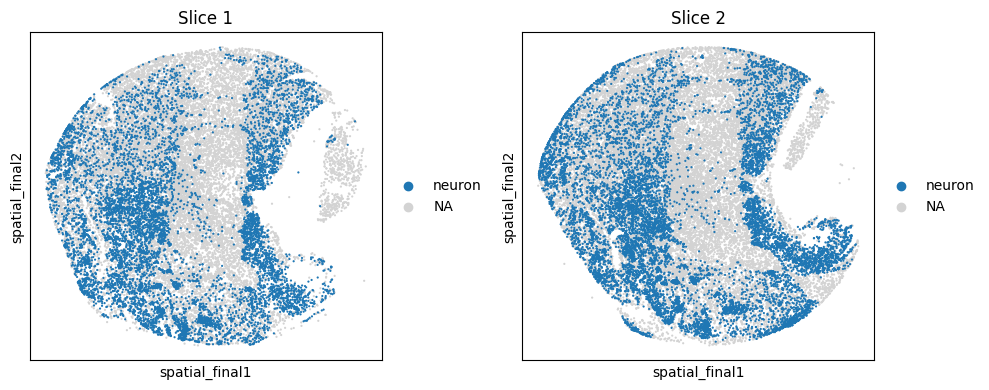

In [ ]:
def mirror_y_axis(coords):
    """Mirror coordinates across y-axis (flip left-right)"""
    coords[:, 0] = -coords[:, 0]
    return coords

def rotate_coords(coords, angle_deg):
    angle_rad = np.radians(angle_deg)
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])
    return coords @ rotation_matrix.T

def normalize_coordinates(coords):
    """
    Transform coordinates to:
    - Start at (0, 0)
    - x increases left to right
    - y increases bottom to top
    """
    coords = coords.copy()
    
    # Shift to start at (0, 0)
    coords[:, 0] -= coords[:, 0].min()
    coords[:, 1] -= coords[:, 1].min()
    
    return coords

# Improve slice 2 
adata_slice_2.obsm["spatial_rot"] = mirror_y_axis(adata_slice_2.obsm["spatial"].copy())

adata_slice_2.obsm["spatial_rot"] = rotate_coords(adata_slice_2.obsm["spatial_rot"], -20)

# Apply to both slices __> neede for Slicer
adata_slice_1.obsm["spatial_final"] = normalize_coordinates(adata_slice_1.obsm["spatial"])
adata_slice_2.obsm["spatial_final"] = normalize_coordinates(adata_slice_2.obsm["spatial_rot"])

# trnaofmr inot cm
PIXEL_SIZE_CM = 0.1  # to not overflow follwing pipeline
adata_slice_1.obsm["spatial_final"] = adata_slice_1.obsm["spatial_final"] * PIXEL_SIZE_CM
adata_slice_2.obsm["spatial_final"] = adata_slice_2.obsm["spatial_final"] * PIXEL_SIZE_CM


fig, ax = plt.subplots(1,2,figsize=(10,4))
sc.pl.embedding(adata_slice_1, basis="spatial_final", color=CELL_TYPE_ANNOTATION,
                groups=[CELL_TYPE_FOR_DISCRIMINATION], size=10, title="Slice 1",
                ax=ax[0], show=False)
sc.pl.embedding(adata_slice_2, basis="spatial_final", color=CELL_TYPE_ANNOTATION,
                groups=[CELL_TYPE_FOR_DISCRIMINATION], size=10, title="Slice 2",
                ax=ax[1], show=False)
plt.tight_layout()

## II: Refine overlap

  0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 21/21 [00:10<00:00,  1.94it/s]

Best angle: 0°


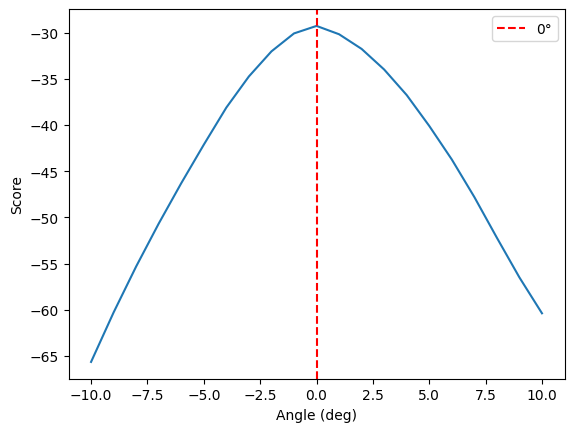

In [6]:
from scipy.spatial.distance import cdist
from tqdm import tqdm

def find_best_rotation(coords_1, coords_2, angle_range=(-45, 45), angle_step=0.5):
    """Find best rotation angle to align coords_2 onto coords_1"""
    
    angles = np.arange(angle_range[0], angle_range[1] + angle_step, angle_step)
    scores = {}
    
    for angle in tqdm(angles):
        # Rotate coords_2
        angle_rad = np.radians(angle)
        rot_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                               [np.sin(angle_rad), np.cos(angle_rad)]])
        coords_2_rot = coords_2 @ rot_matrix.T
        
        # Score: negative mean minimum distance
        scores[angle] = -np.mean(np.min(cdist(coords_2_rot, coords_1), axis=1))
    
    best_angle = max(scores, key=scores.get)
    print(f"Best angle: {best_angle}°")
    
    return best_angle, scores

# Get neuron coordinates
mask_1 = adata_slice_1.obs[CELL_TYPE_ANNOTATION] == CELL_TYPE_FOR_DISCRIMINATION
mask_2 = adata_slice_2.obs[CELL_TYPE_ANNOTATION] == CELL_TYPE_FOR_DISCRIMINATION

coords_1 = adata_slice_1.obsm["spatial_final"][mask_1]
coords_2 = adata_slice_2.obsm["spatial_final"][mask_2]

# Find best rotation
best_angle, scores = find_best_rotation(coords_1, coords_2,angle_range=(-10, 10), angle_step=1)

# Plot
angles = sorted(scores.keys())
plt.plot(angles, [scores[a] for a in angles])
plt.axvline(best_angle, color='r', linestyle='--', label=f'{best_angle}°')
plt.xlabel('Angle (deg)')
plt.ylabel('Score')
plt.legend()
plt.show()

## Save Image one locations

In [7]:
coord_1 = adata_slice_1.obsm["spatial_final"].copy()
coord_2 = adata_slice_2.obsm["spatial_final"].copy() # ATTENTION rot!

# Save slice 1
df = pd.DataFrame({
    's_1': coord_1[:, 0],
    's_2': coord_1[:, 1],
    'bead_numis': adata_slice_1.obs['total_counts'].astype(int).values,
    'category': [1 if ct == CELL_TYPE_FOR_DISCRIMINATION else 0 for ct in adata_slice_1.obs[CELL_TYPE_ANNOTATION]],
})
df.to_csv("/home/gdallagl/myworkdir/XDP/data/_tmp/single_slice_1.csv", index=False)

# Save slice 2
df = pd.DataFrame({
    's_1': coord_2[:, 0],
    's_2': coord_2[:, 1],
    'bead_numis': adata_slice_2.obs['total_counts'].astype(int).values,
    'category': [1 if ct == CELL_TYPE_FOR_DISCRIMINATION else 0 for ct in adata_slice_2.obs[CELL_TYPE_ANNOTATION]],
})
df.to_csv("/home/gdallagl/myworkdir/XDP/data/_tmp/single_slice_2.csv",index=False)


## Save Nissl Image

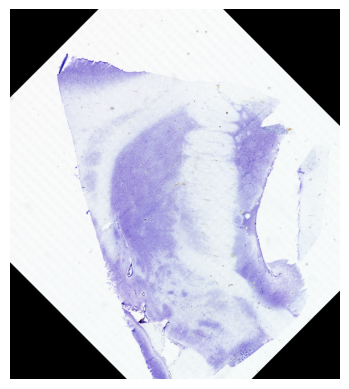

(3343, 3748)


In [14]:
from PIL import Image
import matplotlib.pyplot as plt

# Load JPG
img = Image.open(NISSEL_IMAGE_PATH)

# Rotate 180 degrees
#img = img.rotate(180)
img = img.transpose(Image.FLIP_LEFT_RIGHT)
img = img.rotate(45, expand=False) #counter-clockwise


# Save as PNG
img.save("/home/gdallagl/myworkdir/XDP/data/_tmp/nissl.png", "PNG")

# Plot the rotated image
plt.imshow(img)
plt.axis("off")
plt.show()

print(img.size)


# Overlay

In [32]:
import numpy as np

path = "/home/gdallagl/myworkdir/XDP/data/_tmp/single_slice_1_coords.png_on_fixed.txt"

arr = np.loadtxt(path, delimiter=",")
print(arr.shape)
print(arr)

adata_slice_1.obsm['spatial'] = arr

print(np.min(arr), np.max(arr))

(29044, 2)
[[-785.74225171 -333.2866044 ]
 [-832.51511544 -328.38282987]
 [-852.25621352 -242.53769022]
 ...
 [-780.8744746  -359.45252581]
 [-922.23659852 -343.3631503 ]
 [-884.04071023 -372.14126512]]
-987.7237414473301 -147.14372186591095


In [34]:
arr[:, 0 ] += np.abs(np.min(arr[:, 0]))
arr[:, 1 ] += np.abs(np.min(arr[:, 1]))
print(np.min(arr[:, 0 ]), np.min(arr[:, 1 ]))
arr

0.0 0.0


array([[201.98148974, 105.01868449],
       [155.20862601, 109.92245903],
       [135.46752793, 195.76759868],
       ...,
       [206.84926685,  78.85276308],
       [ 65.48714293,  94.9421386 ],
       [103.68303122,  66.16402377]], shape=(29044, 2))

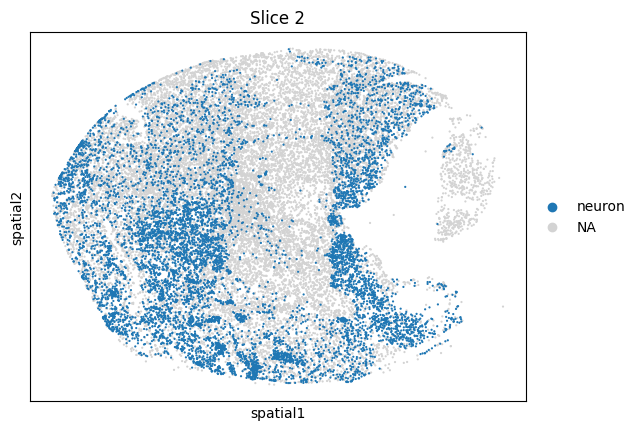

In [16]:
sc.pl.embedding(adata_slice_1, basis="spatial", color=CELL_TYPE_ANNOTATION,
                groups=[CELL_TYPE_FOR_DISCRIMINATION], size=10, title="Slice 2")

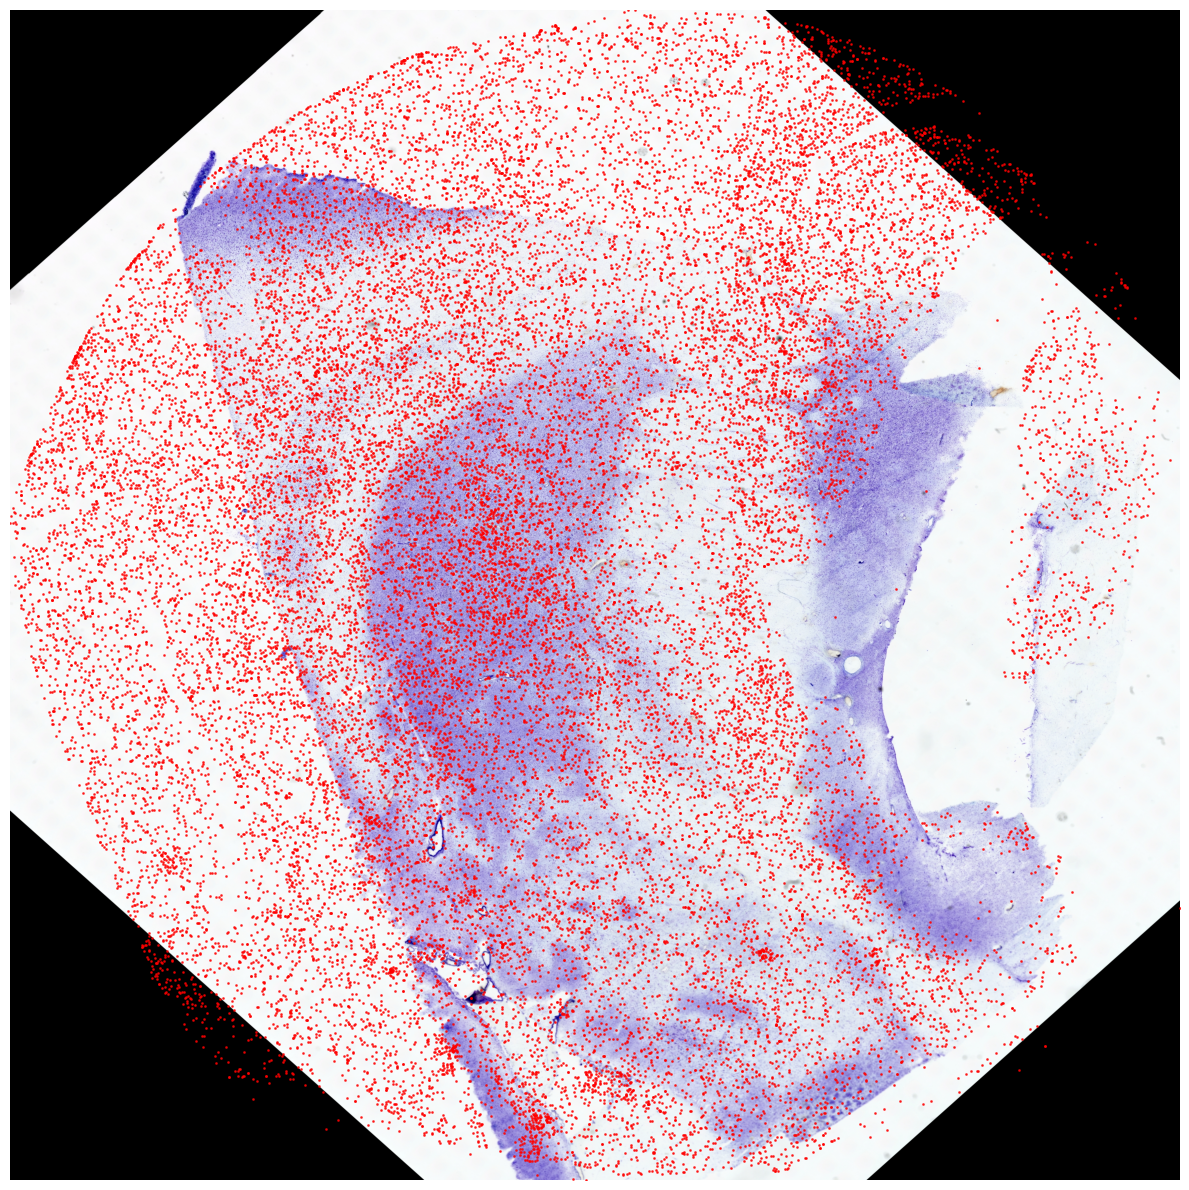

In [35]:
# new_width = 200  # adjust as needed
# new_height = 200  # adjust as needed
# img = img.resize((new_width, new_height), Image.LANCZOS)



# Plot with explicit extent to align them
fig, ax = plt.subplots(figsize=(12, 12))

# Set image extent to match coordinate space
# extent = [left, right, bottom, top]
img_extent = [arr[:,0].min(), arr[:,0].max(), 
              arr[:,1].max(), arr[:,1].min()]  # Note: Y is flipped for images

ax.imshow(img, extent=img_extent, aspect='auto')
ax.scatter(arr[:, 0], arr[:, 1], c='red', s=1, alpha=0.7)
ax.set_xlim(arr[:,0].min(), arr[:,0].max())
ax.set_ylim(arr[:,1].max(), arr[:,1].min())  # Flip Y axis
ax.axis("off")
plt.tight_layout()
plt.show()